In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score,confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from xgboost import XGBRegressor, XGBClassifier
import joblib


In [25]:
# Загрузка данных
data = pd.read_csv('data/data_cl.csv')

In [26]:
if data.isnull().sum().sum() > 0:
    print('Есть пропущенные значения')

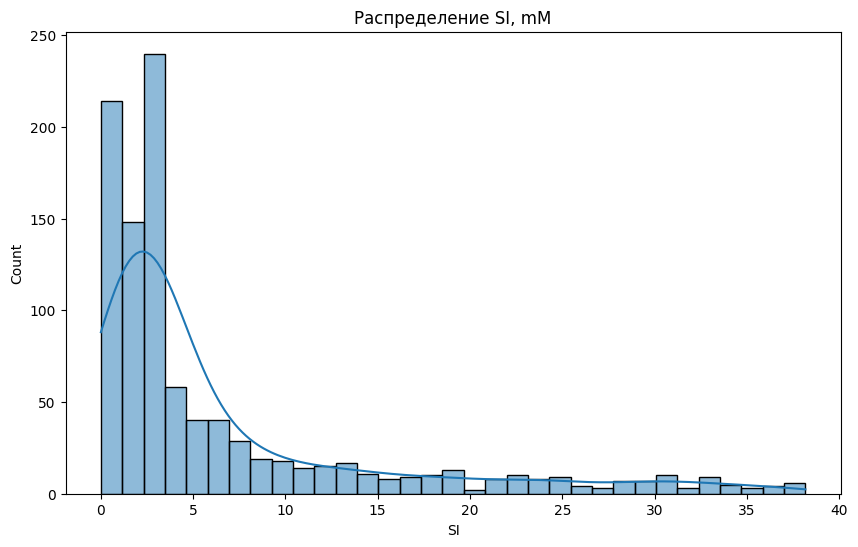

In [27]:
# Визуализация распределения целевой переменной IC50
plt.figure(figsize=(10, 6))
sns.histplot(data['SI'], kde=True)
plt.title('Распределение SI, mM')
plt.savefig('results/SI_distribution.png')
plt.show()

In [28]:
# Разделение на признаки и целевую переменную
X = data.drop(['SI', 'Unnamed: 0'], axis=1)
y_SI = data['SI']

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Для классификации (SI > медианы)

In [29]:
# Создание бинарной целевой переменной
median_SI = y_SI.median()
y_class = (y_SI > median_SI).astype(int)

# Разделение на train/test (те же разбиения, что и для регрессии)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42)


### 3. Модель

In [30]:
def evaluate_models(models, X, y, cv=5):
    """
    Функция для оценки метрик классификации.
    """
    results = {}
    
    for name, model in models.items():
        # Оценка с использованием точности
        accuracy_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        results[name] = {
            'mean_accuracy': accuracy_scores.mean(),
            'std_accuracy': accuracy_scores.std(),
            'all_accuracy_scores': accuracy_scores
        }
        
        # Оценка с использованием F1-меры
        f1_scorer = make_scorer(f1_score, average='weighted')  # Используем weighted для многоклассовой классификации
        f1_scores = cross_val_score(model, X, y, cv=cv, scoring=f1_scorer)
        results[name]['mean_f1'] = f1_scores.mean()
        results[name]['std_f1'] = f1_scores.std()
        results[name]['all_f1_scores'] = f1_scores
        
        # Оценка с использованием полноты (recall)
        recall_scorer = make_scorer(recall_score, average='weighted')
        recall_scores = cross_val_score(model, X, y, cv=cv, scoring=recall_scorer)
        results[name]['mean_recall'] = recall_scores.mean()
        results[name]['std_recall'] = recall_scores.std()
        results[name]['all_recall_scores'] = recall_scores
        
        # Оценка с использованием точности (precision)
        precision_scorer = make_scorer(precision_score, average='weighted')
        precision_scores = cross_val_score(model, X, y, cv=cv, scoring=precision_scorer)
        results[name]['mean_precision'] = precision_scores.mean()
        results[name]['std_precision'] = precision_scores.std()
        results[name]['all_precision_scores'] = precision_scores

    return results

In [31]:
# Классификация

In [32]:
# Инициализация моделей
class_models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVC': SVC(random_state=42),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(random_state=42)
}

In [33]:
# Оценка с кросс-валидацией
class_results = evaluate_models(class_models, X_train_class, y_train_class)

In [34]:
# Вывод результатов классификации
print("Результаты классификации:")
for name, res in class_results.items():
    print(f"{name}:")
    print(f"  Средняя точность: {res['mean_accuracy']:.4f}, стандартное отклонение: {res['std_accuracy']:.4f}")
    print(f"  Средняя F1-меры: {res['mean_f1']:.4f}, стандартное отклонение: {res['std_f1']:.4f}")
    print(f"  Средняя полнота: {res['mean_recall']:.4f}, стандартное отклонение: {res['std_recall']:.4f}")
    print(f"  Средняя точность (precision): {res['mean_precision']:.4f}, стандартное отклонение: {res['std_precision']:.4f}")

Результаты классификации:
Logistic Regression:
  Средняя точность: 0.5875, стандартное отклонение: 0.0259
  Средняя F1-меры: 0.5793, стандартное отклонение: 0.0238
  Средняя полнота: 0.5875, стандартное отклонение: 0.0259
  Средняя точность (precision): 0.5835, стандартное отклонение: 0.0268
Random Forest:
  Средняя точность: 0.7850, стандартное отклонение: 0.0161
  Средняя F1-меры: 0.7837, стандартное отклонение: 0.0148
  Средняя полнота: 0.7850, стандартное отклонение: 0.0161
  Средняя точность (precision): 0.7877, стандартное отклонение: 0.0187
SVC:
  Средняя точность: 0.6038, стандартное отклонение: 0.0320
  Средняя F1-меры: 0.6023, стандартное отклонение: 0.0334
  Средняя полнота: 0.6038, стандартное отклонение: 0.0320
  Средняя точность (precision): 0.6059, стандартное отклонение: 0.0349
KNN:
  Средняя точность: 0.6137, стандартное отклонение: 0.0593
  Средняя F1-меры: 0.6129, стандартное отклонение: 0.0596
  Средняя полнота: 0.6137, стандартное отклонение: 0.0593
  Средняя точно

**Вывод**

XGBoost продемонстрировал наилучшие результаты по всем метрикам:  

   • Средняя точность (0.8838) значительно выше, чем у других моделей.  

   • Высокие значения F1-меры (0.8834), полноты (0.8838) и precision (0.8872) при низком стандартном отклонении (~0.013) указывают на стабильность и надежность модели

In [13]:
# Параметры для поиска
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Поиск по сетке
grid_search = GridSearchCV(
    XGBClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy'
)
grid_search.fit(X_train_class, y_train_class)

# Лучшие параметры
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучшая accuracy: {grid_search.best_score_:.4f}")

# Обучение финальной модели
best_class_model = grid_search.best_estimator_


Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200}
Лучшая accuracy: 0.8138


In [17]:

# Обучение финальной модели
best_class_model = grid_search.best_estimator_

### 4. Подбор гиперпараметров для лучших моделей

In [35]:
# Параметры для поиска
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2]}

In [36]:
# Поиск по сетке
grid_search = GridSearchCV(
    XGBClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy'
)
grid_search.fit(X_train_class, y_train_class)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [37]:
# Лучшие параметры
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучшая accuracy: {grid_search.best_score_:.4f}")

Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200}
Лучшая accuracy: 0.8938


In [38]:
# Обучение финальной модели
best_class_model = grid_search.best_estimator_

### 5. Оценка на тестовом наборе и визуализация

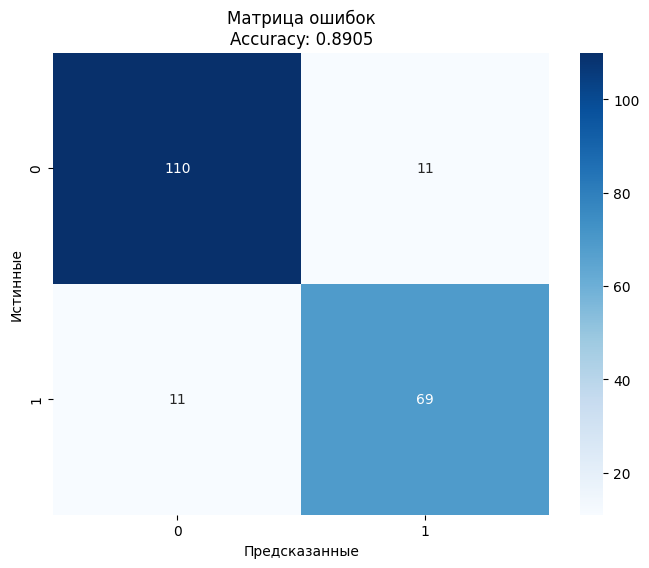

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       121
           1       0.86      0.86      0.86        80

    accuracy                           0.89       201
   macro avg       0.89      0.89      0.89       201
weighted avg       0.89      0.89      0.89       201



In [39]:
# Предсказания
y_pred_class = best_class_model.predict(X_test_class)
accuracy = accuracy_score(y_test_class, y_pred_class)

# Матрица ошибок
cm = confusion_matrix(y_test_class, y_pred_class)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанные')
plt.ylabel('Истинные')
plt.title(f'Матрица ошибок\nAccuracy: {accuracy:.4f}')
plt.savefig('results/classification_confusion_matrix.png')
plt.show()

# Отчет классификации
print(classification_report(y_test_class, y_pred_class))

### 6. Анализ важности признаков

/tmp/ipykernel_1951321/176949010.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Importance', y='Feature', data=features_df, palette='viridis')


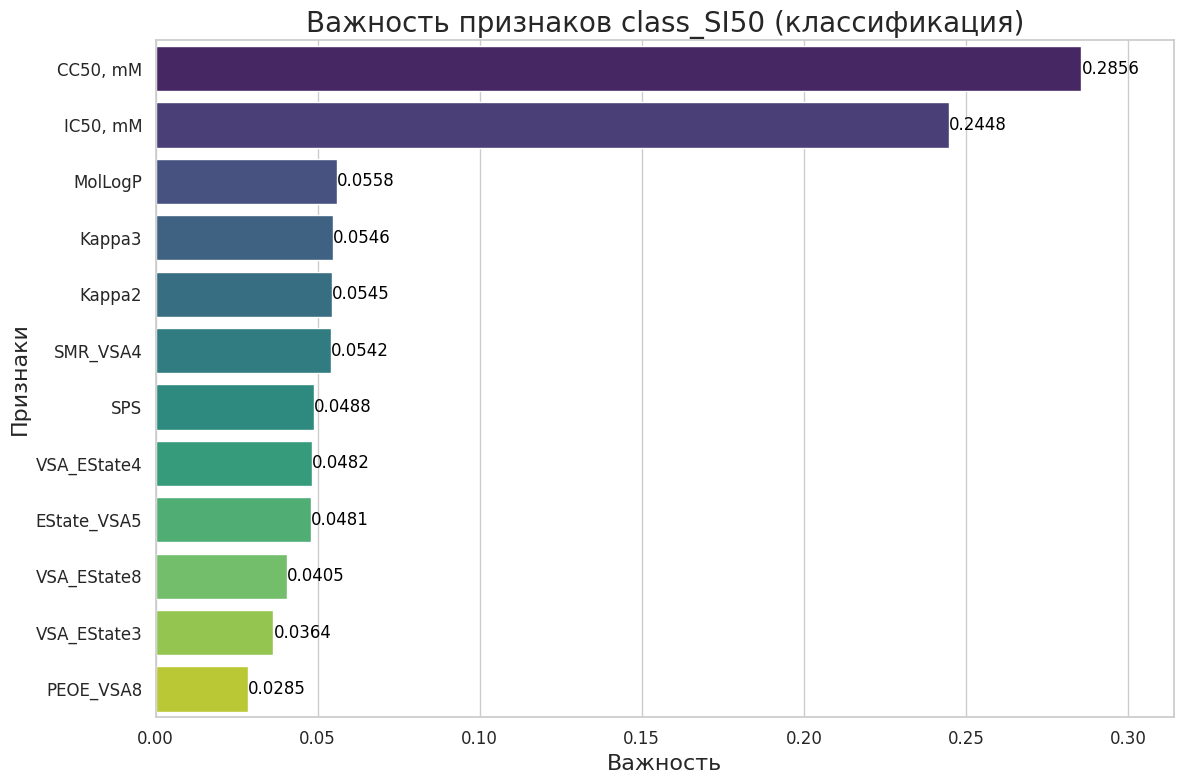

Выводы о важности признаков:
Наиболее важные признаки для модели классификации:
CC50, mM: Важность = 0.2856
IC50, mM: Важность = 0.2448
MolLogP: Важность = 0.0558
Kappa3: Важность = 0.0546
Kappa2: Важность = 0.0545
SMR_VSA4: Важность = 0.0542
SPS: Важность = 0.0488
VSA_EState4: Важность = 0.0482
EState_VSA5: Важность = 0.0481
VSA_EState8: Важность = 0.0405
VSA_EState3: Важность = 0.0364
PEOE_VSA8: Важность = 0.0285

Наиболее важный признак: CC50, mM с важностью 0.2856
Наименее важный признак: PEOE_VSA8 с важностью 0.0285


In [40]:
if hasattr(best_class_model, 'feature_importances_'):
    importances = best_class_model.feature_importances_
    feature_names = X.columns
    features_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    features_df = features_df.sort_values('Importance', ascending=False)

    # Настройка стиля
    sns.set(style='whitegrid')

    plt.figure(figsize=(12, 8))
    bar_plot = sns.barplot(x='Importance', y='Feature', data=features_df, palette='viridis')

    # Добавление значений на столбцах
    for index, value in enumerate(features_df['Importance']):
        bar_plot.text(value, index, f'{value:.4f}', color='black', ha="left", va="center")

    plt.title('Важность признаков class_SI50 (классификация)', fontsize=20)
    plt.xlabel('Важность', fontsize=16)
    plt.ylabel('Признаки', fontsize=16)
    plt.xlim(0, features_df['Importance'].max() * 1.1)  # Увеличение лимита оси X
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.tight_layout()
    plt.savefig('results/feature_importance_сl_SI50.png')
    plt.show()

    # Выводы
    print("Выводы о важности признаков:")
    print("Наиболее важные признаки для модели классификации:")
    for i, row in features_df.iterrows():
        print(f"{row['Feature']}: Важность = {row['Importance']:.4f}")

    # Дополнительные выводы
    most_important_feature = features_df.iloc[0]
    print(f"\nНаиболее важный признак: {most_important_feature['Feature']} с важностью {most_important_feature['Importance']:.4f}")
    
    # Можно добавить вывод о том, какие признаки менее важны
    least_important_feature = features_df.iloc[-1]
    print(f"Наименее важный признак: {least_important_feature['Feature']} с важностью {least_important_feature['Importance']:.4f}")


In [41]:
# Сохранение моделей
joblib.dump(best_class_model, 'results/best_classification_SI50_cl_model.pkl')

['results/best_classification_SI50_cl_model.pkl']